# Various Utilities
Lesser utilities that do not warrant their own script files.

In [150]:
from pathlib import Path
import sqlite3
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np

import time
import json

import utilities.utilities as util

# Find Kakans (Added Kan)

In [ ]:
STATE_LOG_PATH = "E:/mahjong/state_data/"
YEAR = 2019
LOG_RANGE_START = 0
LOG_RANGE_END   = 10000

kakans = []
for p in tqdm([l for l in (Path(STATE_LOG_PATH) / str(YEAR)).iterdir()][LOG_RANGE_START:LOG_RANGE_END], position=0):
    
    if len(kakans) > 10:
        break
    
    df = pd.read_parquet(p)
    
    kakan_df =  df[
                (df['action'] == 'KaKan')
    ]
    
    if len(kakan_df) > 0:
        kakans.append(kakan_df)

for c in kakans:
    row = c.iloc[0]
#     print("LOG ID:", row['log_id'], "\tROUND:", row['round'])
    with pd.option_context('display.max_rows', 1500, 'display.max_columns', 10, 'display.expand_frame_repr', True):
        display(c)

# Find Chankans (Robbing a Kan)

In [36]:
STATE_LOG_PATH = "E:/mahjong/state_data/"
YEAR = 2019
LOG_RANGE_START = 0
LOG_RANGE_END   = 10000

chankans = []
for p in tqdm([l for l in (Path(STATE_LOG_PATH) / str(YEAR)).iterdir()][LOG_RANGE_START:LOG_RANGE_END], position=0):
    
    df = pd.read_parquet(p)
    
    chankan_df =  df[
                ((df['action'] == 'KaKan') & (df['action'].shift(-1) == 'Remove')) | 
                ((df['action'] == 'Remove') & (df['action'].shift(1) == 'KaKan')) |
                ((df['action'] == 'Ron') & (df['action'].shift(1) == 'Remove') & (df['action'].shift(2) == 'KaKan'))
    ]
    
    if len(chankan_df) > 0:
        chankans.append(chankan_df)

for c in chankans:
    row = c.iloc[0]
    print("LOG ID:", row['log_id'], "\tROUND:", row['round'])
#     with pd.option_context('display.max_rows', 1500, 'display.max_columns', 10, 'display.expand_frame_repr', True):
#         display(c)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:06<00:00, 149.73it/s]

LOG ID: 2019010219gm-00a9-0000-082f8f5c 	ROUND: 8
LOG ID: 2019010316gm-00a9-0000-a0b97c96 	ROUND: 5
LOG ID: 2019010321gm-00a9-0000-d77bfbfd 	ROUND: 2
LOG ID: 2019010400gm-00a9-0000-480163f2 	ROUND: 4
LOG ID: 2019010419gm-00a9-0000-ba8c06ac 	ROUND: 3
LOG ID: 2019010514gm-00a9-0000-091e5b82 	ROUND: 11
LOG ID: 2019010823gm-00a9-0000-f900e413 	ROUND: 0
LOG ID: 2019010900gm-00a9-0000-19995591 	ROUND: 12
LOG ID: 2019011012gm-00a9-0000-67d8f32a 	ROUND: 4
LOG ID: 2019011218gm-00a9-0000-c67d29cc 	ROUND: 7
LOG ID: 2019011220gm-00a9-0000-9d8bbffc 	ROUND: 4
LOG ID: 2019011312gm-00a9-0000-591da9f4 	ROUND: 4
LOG ID: 2019011603gm-00a9-0000-06cc39da 	ROUND: 4
LOG ID: 2019011702gm-00a9-0000-e6d46139 	ROUND: 4
LOG ID: 2019011807gm-00a9-0000-a8ceae23 	ROUND: 1
LOG ID: 2019011817gm-00a9-0000-5ad2ba75 	ROUND: 3
LOG ID: 2019011817gm-00a9-0000-c6ecee7c 	ROUND: 12
LOG ID: 2019011822gm-00a9-0000-284574e1 	ROUND: 14
LOG ID: 2019011913gm-00a9-0000-e20a10d7 	ROUND: 1
LOG ID: 2019011916gm-00a9-0000-0069e345 	ROUND

# Count occurences of calls

```
dict format: 
{ mjlog_ID: 
    [
        p0: {'Chi': 0, 'Pon': 0, 'Kan': 0}
        p1: {'Chi': 0, 'Pon': 0, 'Kan': 0}
        p2: {'Chi': 0, 'Pon': 0, 'Kan': 0}
        p3: {'Chi': 0, 'Pon': 0, 'Kan': 0}
    ],
    [
        p0: {'Chi': 0, 'Pon': 0, 'Kan': 0}
        p1: {'Chi': 0, 'Pon': 0, 'Kan': 0}
        p2: {'Chi': 0, 'Pon': 0, 'Kan': 0}
        p3: {'Chi': 0, 'Pon': 0, 'Kan': 0})
    ],
    ...
}
```

In [40]:
JSON_LOG_PATH = "E:/mahjong/logs_json/"

for year in Path(JSON_LOG_PATH).iterdir():
    
    calls_counts = {}  # See above log format
    
    all_logs = [ll for ll in year.iterdir()]

    for log in tqdm(all_logs, total=len(all_logs), desc=year.stem):
        
        calls_counts[log.stem] = []
        
        log_dict = json.loads(log.read_text())

        for game_round in log_dict['rounds']:

            _round = [{'Chi': 0, 'Pon': 0, 'MinKan': 0, 'KaKan': 0, 'AnKan': 0, 'Nuki': 0} for _ in range(4)]

            for action in game_round:
                if action['tag'] == 'CALL':
                    player = action['data']["caller"]
                    call_type = action['data']["call_type"]
                    _round[player][call_type] += 1

            calls_counts[log.stem].append(_round)
    
    # Convert dict to pandas then to .feather file
    rows = []
    for log_id, rounds in tqdm(calls_counts.items()):
        for round_num, round_info in enumerate(rounds):
            row = {"log_id": log_id, "round_number": round_num}
            for player_id, player_calls in enumerate(round_info):
                for call_type, call_counts in player_calls.items():
                    row[f'p{player_id}-{call_type}'] = call_counts
            # {'Chi': 0, 'Pon': 0, 'MinKan': 0, 'KaKan': 0, 'AnKan': 0, 'Nuki': 0} for _ in range(4)

            rows.append(row)
    
df = pd.DataFrame(rows)

2009:   6%|███▉                                                                  | 4490/80156 [00:05<01:33, 806.94it/s]


KeyboardInterrupt: 

# Find Largest number of discards done by players
Careful! This is finding the highest number of discards given a player! As players can call on player's discards, and therefore taking the discarded tile away from the pool.

In other words: 

**A player's discard pool is a subset of a player's discards**. 

In [41]:
years = [
    '2009',
    '2010',
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018',
    '2019',
]

rows = []

path = Path("E:/mahjong/logs_json/")
for year in path.iterdir():
    
    if year.stem not in years:
        continue

    all_logs = [ll for ll in year.iterdir()]

    for log in tqdm(all_logs, total=len(all_logs), desc=year.stem):

        log_json = json.load(log.open())

        for rn, _round in enumerate(log_json['rounds']):

            discard_counts = [0, 0, 0, 0]
            for action in _round:
                if action['tag'] == 'DISCARD':
                    player = action['data']['player']
                    discard_counts[player] += 1

            row = {
                'log_id': log.stem,
                 'round': rn,
                    'p0': discard_counts[0],
                    'p1': discard_counts[1],
                    'p2': discard_counts[2],
                    'p3': discard_counts[3]
            }

            rows.append(row)

2009:   2%|█▋                                                                    | 1937/80156 [00:02<01:39, 786.97it/s]


KeyboardInterrupt: 

In [6]:
df = pd.DataFrame(rows)
df

,log_id,round,p0-discards,p1-discards,p2-discards,p3-discards,p0-pool,p1-pool,p2-pool,p3-pool
0,2009020103gm-00a9-0000-2453a04c,0,18,18,17,17,18,18,17,17
1,2009020103gm-00a9-0000-2453a04c,1,17,18,18,17,17,18,18,17
2,2009020103gm-00a9-0000-2453a04c,2,17,17,18,18,17,17,18,18
3,2009020103gm-00a9-0000-2453a04c,3,18,17,17,18,18,17,17,18
4,2009020103gm-00a9-0000-2453a04c,4,18,18,17,17,18,18,17,17
...,...,...,...,...,...,...,...,...,...,...
23112755,2019122706gm-00b1-0000-b087b029,1,8,9,9,0,8,9,7,0
23112756,2019122706gm-00b1-0000-b087b029,2,5,5,6,0,5,5,5,0
23112757,2019122706gm-00b1-0000-c3904f65,0,11,11,10,0,11,11,10,0
23112758,2019122706gm-00b1-0000-c3904f65,1,11,11,11,0,10,11,11,0


In [7]:
df.to_feather(Path('D:') / 'accumulated_pandas' / f"better_discard_counts.feather")

In [99]:
game_data = pd.read_parquet(Path('E:') / 'mahjong' / 'pandas' / 'log_game_data.parquet')

In [100]:
# Retrieve years the logs are from
game_data.insert(0, 'year', game_data.index.str[:4].astype(int))
game_data

,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2009020103gm-00a9-0000-2453a04c,2009,True,True,True,False,False,0,0,0,0,1500.00,1500.00,1509.00,1500.00
2009020103gm-00a9-0000-47e70b77,2009,True,True,True,False,False,0,0,0,0,1500.00,1500.00,1500.00,1500.00
2009022011gm-00a9-0000-d7935c6d,2009,True,True,True,False,False,16,16,16,16,2096.00,2000.00,2030.00,2008.00
2009022011gm-00e1-0000-2820118d,2009,True,True,False,False,True,17,16,16,17,2011.00,2032.00,2090.00,2070.00
2009022011gm-00e1-0000-293fb785,2009,True,True,False,False,True,16,16,17,17,2034.00,2089.00,2004.00,2068.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019123123gm-00e1-0000-99d83b7a,2019,True,True,False,False,True,16,16,16,16,2061.34,2187.98,2075.11,2122.54
2019123123gm-00e1-0000-c92676e9,2019,True,True,False,False,True,16,16,16,17,2034.50,2085.77,2074.37,2179.28
2019123123gm-00e1-0000-cf8b36ed,2019,True,True,False,False,True,18,16,17,16,2240.79,2036.80,2172.86,2072.47


## Filtered Version

In [133]:
filtered_game_data = util.filter_logs(game_data)
filtered_game_data

,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2009022011gm-00a9-0000-d7935c6d,2009,True,True,True,False,False,16,16,16,16,2096.00,2000.00,2030.00,2008.00
2009022020gm-00a9-0000-28418029,2009,True,True,True,False,False,17,16,16,16,2043.00,2058.00,2024.00,2044.00
2009022021gm-00a9-0000-246550e3,2009,True,True,True,False,False,16,16,16,17,2068.00,2020.00,2123.00,2095.00
2009022021gm-00a9-0000-3bacedde,2009,True,True,True,False,False,17,16,16,16,2049.00,2121.00,2070.00,2092.00
2009022021gm-00a9-0000-4879b095,2009,True,True,True,False,False,17,16,16,16,2102.00,2064.00,2028.00,2156.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019123123gm-00a9-0000-cd0c84d8,2019,True,True,True,False,False,17,16,16,17,2208.53,2100.00,2163.85,2158.03
2019123123gm-00a9-0000-ceab322a,2019,True,True,True,False,False,16,16,16,16,2151.90,2092.36,2081.30,2093.02
2019123123gm-00a9-0000-d9881584,2019,True,True,True,False,False,17,16,17,17,2158.95,2122.33,2216.35,2166.84


# Number of Logs per Year

In [128]:
num_year_logs = game_data.year.value_counts().sort_index().rename('Original')  # Original
num_logs_filtered = filtered_game_data.year.value_counts().sort_index().rename('Filtered')  # Filtered

num_log_df = pd.DataFrame([num_year_logs, num_logs_filtered]).T

display(num_log_df)
print("Original Total:", num_log_df['Original'].sum())
print("Filtered Total:", num_log_df['Filtered'].sum())

,Original,Filtered
2009,80156,6895
2010,149606,70228
2011,217011,100814
2012,263589,116985
2013,250790,131838
2014,244154,141132
2015,249916,152280
2016,252064,159665
2017,251966,169384
2018,267801,173548


Original Total: 2506325
Filtered Total: 1394398


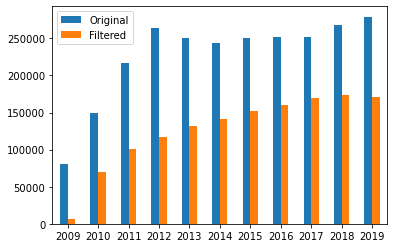

In [119]:
log_plot = num_log_df.plot.bar(rot=0)

# Game Configs Distribution

In [121]:
config_distribution = game_data[['red', 'kui', 'soku', 'ton-nan', 'sanma']].value_counts(sort=False, normalize=True)
config_distribution

red    kui    soku   ton-nan  sanma
False  False  False  False    False    0.000093
                     True     False    0.000009
       True   False  False    False    0.000019
                     True     False    0.000858
True   True   False  False    False    0.000642
                              True     0.001957
                     True     False    0.556353
                              True     0.215568
              True   False    False    0.223201
                              True     0.000182
                     True     False    0.000747
                              True     0.000371
dtype: float64

In [122]:
ans = [pd.DataFrame(y) for x, y in game_data.groupby('year', as_index=False)]
for a in ans:
    display(a)

,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2009020103gm-00a9-0000-2453a04c,2009,True,True,True,False,False,0,0,0,0,1500.0,1500.0,1509.0,1500.0
2009020103gm-00a9-0000-47e70b77,2009,True,True,True,False,False,0,0,0,0,1500.0,1500.0,1500.0,1500.0
2009022011gm-00a9-0000-d7935c6d,2009,True,True,True,False,False,16,16,16,16,2096.0,2000.0,2030.0,2008.0
2009022011gm-00e1-0000-2820118d,2009,True,True,False,False,True,17,16,16,17,2011.0,2032.0,2090.0,2070.0
2009022011gm-00e1-0000-293fb785,2009,True,True,False,False,True,16,16,17,17,2034.0,2089.0,2004.0,2068.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009123123gm-00b9-0000-df5848c3,2009,True,True,True,True,False,16,16,17,0,2083.0,2052.0,2208.0,1500.0
2009123123gm-00e1-0000-1249fbdb,2009,True,True,False,False,True,16,17,16,16,2078.0,2156.0,2033.0,2080.0
2009123123gm-00e1-0000-925762e0,2009,True,True,False,False,True,17,16,16,16,2088.0,2051.0,2082.0,2055.0


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2010010100gm-00a9-0000-643112c2,2010,True,True,True,False,False,17,16,16,17,2119.00,2024.00,2077.00,2175.00
2010010100gm-00a9-0000-7878c3d7,2010,True,True,True,False,False,16,18,16,16,2059.00,2161.00,2062.00,2164.00
2010010100gm-00a9-0000-84702fc7,2010,True,True,True,False,False,17,16,17,16,2184.00,2056.00,2157.00,2118.00
2010010100gm-00a9-0000-ba909b85,2010,True,True,True,False,False,17,16,18,16,2094.00,2052.00,2181.00,2117.00
2010010100gm-00a9-0000-bd257ef0,2010,True,True,True,False,False,17,16,16,16,2125.00,2026.00,2086.00,2078.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010123123gm-00e1-0000-9742ffef,2010,True,True,False,False,True,17,16,16,16,2192.16,2014.01,2086.41,2126.04
2010123123gm-00e1-0000-c41b6ffd,2010,True,True,False,False,True,16,17,16,16,2072.16,2095.58,2112.35,2065.73
2010123123gm-00e1-0000-d14852ab,2010,True,True,False,False,True,16,16,16,17,2067.32,2139.04,2135.73,2198.47


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2011010100gm-00a9-0000-3f2ec5bf,2011,True,True,True,False,False,16,16,17,16,2114.43,2072.35,2180.95,2100.70
2011010100gm-00a9-0000-58aad5ff,2011,True,True,True,False,False,17,17,16,17,2138.00,2179.51,2086.55,2133.12
2011010100gm-00a9-0000-62b8f3b1,2011,True,True,True,False,False,16,16,17,16,2142.38,2102.79,2205.53,2048.68
2011010100gm-00a9-0000-73f38476,2011,True,True,True,False,False,16,19,16,16,2138.12,2235.99,2124.80,2112.00
2011010100gm-00a9-0000-8082a76d,2011,True,True,True,False,False,16,17,16,16,2074.24,2188.28,2075.42,2046.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011123123gm-00e1-0000-97866547,2011,True,True,False,False,True,17,17,16,16,2154.83,2168.68,2115.97,2112.76
2011123123gm-00e1-0000-9ee8823f,2011,True,True,False,False,True,17,16,17,16,2143.97,2114.15,2156.43,2086.43
2011123123gm-00e1-0000-b6b2d1d0,2011,True,True,False,False,True,16,16,16,17,2185.86,2118.09,2098.15,2152.75


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2012010100gm-00a9-0000-11d70799,2012,True,True,True,False,False,16,16,16,16,2108.59,2132.06,2091.20,2108.81
2012010100gm-00a9-0000-45062674,2012,True,True,True,False,False,17,17,16,16,2130.99,2185.84,2072.07,2092.01
2012010100gm-00a9-0000-48ff9b65,2012,True,True,True,False,False,16,17,16,16,2110.60,2099.63,2118.51,2156.40
2012010100gm-00a9-0000-51f3797c,2012,True,True,True,False,False,17,16,18,17,2165.15,2011.83,2184.14,2150.34
2012010100gm-00a9-0000-5e65d279,2012,True,True,True,False,False,16,16,16,16,2049.29,2098.84,2098.53,2088.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012123123gm-00e1-0000-733f10e5,2012,True,True,False,False,True,16,17,18,16,2163.29,2186.89,2222.13,2147.79
2012123123gm-00e1-0000-9380c94e,2012,True,True,False,False,True,16,16,16,17,2168.71,2120.82,2119.32,2190.70
2012123123gm-00e1-0000-a96a6d81,2012,True,True,False,False,True,17,17,18,17,2193.63,2195.76,2272.61,2275.11


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2013010100gm-00a9-0000-0ba7ddbe,2013,True,True,True,False,False,19,17,16,16,2223.80,2197.96,2146.32,2025.09
2013010100gm-00a9-0000-0dac4fed,2013,True,True,True,False,False,17,16,16,16,2166.69,2102.55,2049.45,2116.27
2013010100gm-00a9-0000-175c3aea,2013,True,True,True,False,False,16,18,16,16,2045.42,2234.56,2083.72,2140.82
2013010100gm-00a9-0000-19568f79,2013,True,True,True,False,False,17,16,16,17,2185.38,2054.69,2114.83,2111.52
2013010100gm-00a9-0000-3011979c,2013,True,True,True,False,False,16,16,16,17,2081.94,2047.83,2043.75,2162.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013123123gm-00b9-0000-955b3ab4,2013,True,True,True,True,False,16,17,16,0,2101.87,2261.64,2171.14,1500.00
2013123123gm-00b9-0000-e141e5fb,2013,True,True,True,True,False,17,16,16,0,2234.24,2198.80,2121.94,1500.00
2013123123gm-00b9-0000-f517f08c,2013,True,True,True,True,False,17,17,16,0,2191.37,2260.97,2096.85,1500.00


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2014010100gm-00a7-0000-7ab9a4c7,2014,False,False,False,False,False,17,16,16,17,2150.05,2016.69,2114.29,2173.48
2014010100gm-00a9-0000-29d89b89,2014,True,True,True,False,False,19,18,18,16,2259.51,2197.33,2238.21,2144.84
2014010100gm-00a9-0000-2a19cc5b,2014,True,True,True,False,False,16,17,18,16,2092.40,2133.05,2179.29,2038.06
2014010100gm-00a9-0000-4c462dc0,2014,True,True,True,False,False,17,16,16,16,2155.93,2095.76,2055.03,2171.27
2014010100gm-00a9-0000-4dc389a5,2014,True,True,True,False,False,17,16,17,16,2209.35,2036.91,2242.04,2056.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014123123gm-00e1-0000-436edf19,2014,True,True,False,False,True,16,16,16,16,2110.89,2153.53,2188.26,2081.67
2014123123gm-00e1-0000-667a4db3,2014,True,True,False,False,True,16,16,16,16,2101.78,2175.35,2131.34,2111.30
2014123123gm-00e1-0000-98f50302,2014,True,True,False,False,True,16,16,16,16,2065.37,2134.43,2083.57,2125.19


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2015010100gm-00a9-0000-028b31cb,2015,True,True,True,False,False,17,16,16,16,2215.30,2110.80,2105.92,2139.79
2015010100gm-00a9-0000-26cb5274,2015,True,True,True,False,False,16,16,16,16,2077.37,2101.58,2121.37,2072.20
2015010100gm-00a9-0000-275a2dcc,2015,True,True,True,False,False,16,17,16,17,2101.54,2138.38,2011.30,2197.71
2015010100gm-00a9-0000-2863f966,2015,True,True,True,False,False,18,16,16,16,2284.40,2097.74,2089.65,2099.37
2015010100gm-00a9-0000-2d07e1ae,2015,True,True,True,False,False,17,17,17,16,2142.26,2203.96,2225.98,2040.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015123123gm-00b9-0000-c9e18967,2015,True,True,True,True,False,16,17,17,0,2257.57,2251.90,2314.09,1500.00
2015123123gm-00e1-0000-050ceec0,2015,True,True,False,False,True,18,16,16,17,2205.67,2147.48,2022.93,2171.74
2015123123gm-00e1-0000-278f8a90,2015,True,True,False,False,True,17,17,16,18,2177.57,2184.11,2149.43,2203.33


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2016010100gm-00a1-0000-37bf5c4d,2016,True,True,False,False,False,16,16,16,16,2145.48,2017.51,2199.69,2106.93
2016010100gm-00a9-0000-0d49dc14,2016,True,True,True,False,False,16,17,16,18,2143.22,2205.28,2054.33,2148.04
2016010100gm-00a9-0000-1c8cc802,2016,True,True,True,False,False,17,17,16,16,2117.83,2218.50,2158.13,2014.90
2016010100gm-00a9-0000-243cf36f,2016,True,True,True,False,False,18,18,16,16,2226.61,2180.98,2109.11,2104.60
2016010100gm-00a9-0000-383cc8e9,2016,True,True,True,False,False,16,16,18,18,2065.46,2076.95,2237.53,2276.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016123123gm-00b9-0000-c6f6136a,2016,True,True,True,True,False,17,17,17,0,2236.37,2278.06,2168.74,1500.00
2016123123gm-00e1-0000-75f5f964,2016,True,True,False,False,True,16,16,16,17,2168.54,2134.94,2099.90,2201.65
2016123123gm-00e1-0000-78621a1a,2016,True,True,False,False,True,16,16,16,16,2191.36,2082.79,2134.07,2077.40


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2017010100gm-00a9-0000-003dbd5d,2017,True,True,True,False,False,16,17,16,16,2144.89,2180.88,2117.20,2064.25
2017010100gm-00a9-0000-07e17ac2,2017,True,True,True,False,False,16,16,17,16,2132.01,2164.05,2131.29,2157.79
2017010100gm-00a9-0000-1e68bfe8,2017,True,True,True,False,False,17,16,16,18,2143.08,2022.40,2135.49,2264.22
2017010100gm-00a9-0000-1fb7779d,2017,True,True,True,False,False,16,16,17,17,2097.70,2118.82,2157.88,2107.45
2017010100gm-00a9-0000-28e7d61f,2017,True,True,True,False,False,17,16,16,16,2168.64,2093.24,2157.74,2079.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017123123gm-00b9-0000-ecbd95ea,2017,True,True,True,True,False,16,17,16,0,2193.58,2227.47,2244.08,1500.00
2017123123gm-00e1-0000-d2f0fc3e,2017,True,True,False,False,True,16,16,17,16,2139.59,2064.67,2230.99,2159.16
2017123123gm-00e1-0000-e2cd5cda,2017,True,True,False,False,True,18,17,16,16,2210.16,2229.33,2066.20,2133.45


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2018010100gm-00a9-0000-0d318262,2018,True,True,True,False,False,16,17,16,16,2112.78,2150.01,2049.02,2150.09
2018010100gm-00a9-0000-20643180,2018,True,True,True,False,False,19,16,16,18,2300.31,2126.28,2070.92,2303.00
2018010100gm-00a9-0000-257139d7,2018,True,True,True,False,False,16,16,16,16,2115.04,2118.39,2271.80,2131.17
2018010100gm-00a9-0000-335e91cb,2018,True,True,True,False,False,16,16,16,17,2123.38,2064.90,2168.87,2194.38
2018010100gm-00a9-0000-3d21438c,2018,True,True,True,False,False,16,16,17,16,2081.35,2112.60,2266.80,2117.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018123123gm-00e1-0000-01a8b0ba,2018,True,True,False,False,True,16,17,17,17,2193.09,2215.69,2250.88,2180.02
2018123123gm-00e1-0000-3a4af40d,2018,True,True,False,False,True,16,16,17,16,2078.37,2197.53,2189.93,2138.13
2018123123gm-00e1-0000-41499b11,2018,True,True,False,False,True,16,16,17,17,2083.89,2144.20,2187.74,2271.29


,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2019010100gm-00a9-0000-009379d9,2019,True,True,True,False,False,18,16,17,16,2234.75,2142.95,2176.73,2112.75
2019010100gm-00a9-0000-127203b5,2019,True,True,True,False,False,16,18,17,16,2168.81,2237.23,2228.00,2141.31
2019010100gm-00a9-0000-1f1a5f1f,2019,True,True,True,False,False,16,17,16,17,2113.31,2157.08,2105.71,2226.89
2019010100gm-00a9-0000-4f5e8a98,2019,True,True,True,False,False,17,17,16,16,2189.83,2189.71,2135.24,2138.55
2019010100gm-00a9-0000-56ec7b96,2019,True,True,True,False,False,17,16,18,17,2163.05,2112.33,2210.92,2202.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019123123gm-00e1-0000-99d83b7a,2019,True,True,False,False,True,16,16,16,16,2061.34,2187.98,2075.11,2122.54
2019123123gm-00e1-0000-c92676e9,2019,True,True,False,False,True,16,16,16,17,2034.50,2085.77,2074.37,2179.28
2019123123gm-00e1-0000-cf8b36ed,2019,True,True,False,False,True,18,16,17,16,2240.79,2036.80,2172.86,2072.47


# Various Plotting

In [130]:
game_data

,year,red,kui,ton-nan,sanma,soku,p0-dan,p1-dan,p2-dan,p3-dan,p0-rating,p1-rating,p2-rating,p3-rating
log_id,,,,,,,,,,,,,,
2009020103gm-00a9-0000-2453a04c,2009,True,True,True,False,False,0,0,0,0,1500.00,1500.00,1509.00,1500.00
2009020103gm-00a9-0000-47e70b77,2009,True,True,True,False,False,0,0,0,0,1500.00,1500.00,1500.00,1500.00
2009022011gm-00a9-0000-d7935c6d,2009,True,True,True,False,False,16,16,16,16,2096.00,2000.00,2030.00,2008.00
2009022011gm-00e1-0000-2820118d,2009,True,True,False,False,True,17,16,16,17,2011.00,2032.00,2090.00,2070.00
2009022011gm-00e1-0000-293fb785,2009,True,True,False,False,True,16,16,17,17,2034.00,2089.00,2004.00,2068.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019123123gm-00e1-0000-99d83b7a,2019,True,True,False,False,True,16,16,16,16,2061.34,2187.98,2075.11,2122.54
2019123123gm-00e1-0000-c92676e9,2019,True,True,False,False,True,16,16,16,17,2034.50,2085.77,2074.37,2179.28
2019123123gm-00e1-0000-cf8b36ed,2019,True,True,False,False,True,18,16,17,16,2240.79,2036.80,2172.86,2072.47


## Average Table Rating
We calculate the mean of players' ratings for each log.

In [136]:
player_rating_columns = ['p0-rating', 'p1-rating', 'p2-rating', 'p3-rating']
average_table_ratings = filtered_game_data[player_rating_columns].mean(axis=1)
average_table_ratings.reset_index(drop=True, inplace=True)
average_table_ratings

0          2033.5000
1          2042.2500
2          2076.5000
3          2083.0000
4          2087.5000
             ...    
1394393    2157.6025
1394394    2104.6450
1394395    2166.1175
1394396    2059.9075
1394397    2156.1325
Length: 1394398, dtype: float64

In [138]:
print("Average Table Rating: {:>8.2f}".format(statistics.mean(average_table_ratings)))
print("Median Table Rating:  {:>8.2f}".format(statistics.median(average_table_ratings)))
print("Max Table Rating:     {:>8.2f}".format(max(average_table_ratings)))
print("Min Table Rating:     {:>8.2f}".format(min(average_table_ratings)))

Average Table Rating:  2135.74
Median Table Rating:   2135.03
Max Table Rating:      2293.14
Min Table Rating:      2016.98


### Plotting

In [139]:
# Plot Params
## X-Axis
min_rating = 2000
max_words = 2300
shift = 4
tick_shift = 100

## Y-Axis
max_reviews = 110000
y_shift = 10000

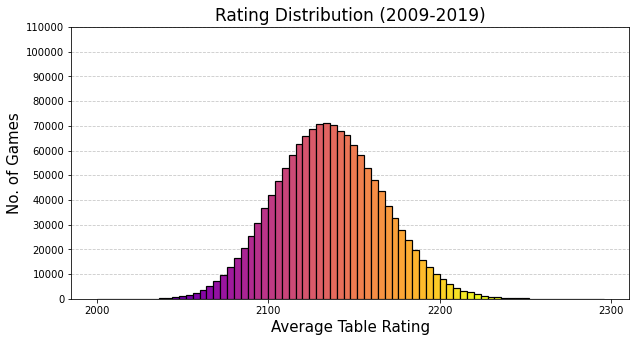

Number of occurence not shown: 0


In [141]:
cm = plt.cm.get_cmap('plasma')  # Other noteworthy ones: 'plasma', 'Spectral'

plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.tick_params(axis='x', rotation=0)
n, bins, patches = plt.hist(average_table_ratings, 
                            bins=range(min_rating, max_words, shift),
#                             density=True, 
                            edgecolor='black', 
                            linewidth=1.2
                           )

for i, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(i/55))  # Change this value to diversify color


plt.title("Rating Distribution (2009-2019)", fontsize=17)
plt.xticks(np.arange(min_rating, max_words + tick_shift, tick_shift))
plt.yticks(np.arange(0, max_reviews + y_shift, y_shift))
plt.ylim(0, max_reviews)

plt.xlabel("Average Table Rating", fontsize=15)
plt.ylabel("No. of Games", fontsize=15)
# plt.savefig(imdb_graphs_output / 'IMDB_length_unprocessed_en', bbox_inches='tight')
plt.show()

print("Number of occurence not shown:", sum((x > max_words or x < min_rating) for x in average_table_ratings))

# Discard Pile Size Plot (FIX - REMOVE SANMA GAMES?)

In [231]:
discard_count_df = pd.read_feather(Path('E:') / 'mahjong' / 'pandas' / 'discard_counts.feather')
discard_count_df = discard_count_df[discard_count_df.log_id.isin(filtered_game_data.index)]  # Filterblade
discard_count_df

,log_id,round,p0-discards,p1-discards,p2-discards,p3-discards,p0-pool,p1-pool,p2-pool,p3-pool
42,2009022011gm-00a9-0000-d7935c6d,0,12,12,12,11,11,12,12,11
43,2009022011gm-00a9-0000-d7935c6d,1,15,16,16,15,14,15,15,14
44,2009022011gm-00a9-0000-d7935c6d,2,14,13,14,14,13,13,13,14
45,2009022011gm-00a9-0000-d7935c6d,3,16,15,15,16,16,15,15,16
46,2009022011gm-00a9-0000-d7935c6d,4,10,10,10,9,9,10,10,8
...,...,...,...,...,...,...,...,...,...,...
22296061,2019123123gm-00a9-0000-f4386d0e,7,11,12,11,10,11,12,9,10
22296062,2019123123gm-00a9-0000-f4386d0e,8,8,7,7,7,8,7,7,7
22296063,2019123123gm-00a9-0000-f4386d0e,9,17,17,18,18,16,17,18,18
22296064,2019123123gm-00a9-0000-f4386d0e,10,6,6,6,6,6,6,6,6


In [232]:
max_discard = discard_count_df[['p0-discards', 'p1-discards', 'p2-discards', 'p3-discards']].max(axis=1)
max_pool = discard_count_df[['p0-pool', 'p1-pool', 'p2-pool', 'p3-pool']].max(axis=1)

max_discard.max(), max_pool.max()

(23, 22)

In [233]:
all_players_discards = discard_count_df[['p0-discards', 'p1-discards', 'p2-discards', 'p3-discards']].stack().reset_index(drop=True)
all_players_pool     = discard_count_df[['p0-pool', 'p1-pool', 'p2-pool', 'p3-pool']].stack().reset_index(drop=True)

In [234]:
total_game_discards = discard_count_df[['p0-discards', 'p1-discards', 'p2-discards', 'p3-discards']].sum(axis=1).value_counts().sort_index()

In [281]:
discard_count_df['total_discards'] = discard_count_df[['p0-discards', 'p1-discards', 'p2-discards', 'p3-discards']].sum(axis=1)
discard_count_df['total_pool_size'] = discard_count_df[['p0-pool', 'p1-pool', 'p2-pool', 'p3-pool']].sum(axis=1)
discard_count_df

,log_id,round,p0-discards,p1-discards,p2-discards,p3-discards,p0-pool,p1-pool,p2-pool,p3-pool,total_discards,total_pool_size
42,2009022011gm-00a9-0000-d7935c6d,0,12,12,12,11,11,12,12,11,47,46
43,2009022011gm-00a9-0000-d7935c6d,1,15,16,16,15,14,15,15,14,62,58
44,2009022011gm-00a9-0000-d7935c6d,2,14,13,14,14,13,13,13,14,55,53
45,2009022011gm-00a9-0000-d7935c6d,3,16,15,15,16,16,15,15,16,62,62
46,2009022011gm-00a9-0000-d7935c6d,4,10,10,10,9,9,10,10,8,39,37
...,...,...,...,...,...,...,...,...,...,...,...,...
22296061,2019123123gm-00a9-0000-f4386d0e,7,11,12,11,10,11,12,9,10,44,42
22296062,2019123123gm-00a9-0000-f4386d0e,8,8,7,7,7,8,7,7,7,29,29
22296063,2019123123gm-00a9-0000-f4386d0e,9,17,17,18,18,16,17,18,18,70,69
22296064,2019123123gm-00a9-0000-f4386d0e,10,6,6,6,6,6,6,6,6,24,24


In [282]:
discard_count_df.total_discards.max(), discard_count_df.total_pool_size.max()

(82, 70)

# Games and their maximum Phase
The following code proves that some rounds do not reach mid game or late game.
Note: This is round-wise count, whereas when we train our models, we use state-based count. However, this metrics are worth writing about:

In [283]:
discard_count_df.total_discards.groupby(pd.cut(discard_count_df.total_discards, (0, 24, 48, 100))).count()

total_discards
(0, 24]       980403
(24, 48]     6890926
(48, 100]    7038697
Name: total_discards, dtype: int64

In [285]:
discard_count_df.total_pool_size.groupby(pd.cut(discard_count_df.total_pool_size, (0, 24, 48, 100))).count()

total_pool_size
(0, 24]      1270489
(24, 48]     7226611
(48, 100]    6412926
Name: total_pool_size, dtype: int64

In [350]:
# Plot Params
## X-Axis
min_rating = 0
max_words = 82
tick_shift = 2

## Y-Axis
max_reviews = 2_500_000
y_shift = 500_000

In [351]:
accumulated_df = pd.DataFrame({"Discards": discard_count_df.total_discards.value_counts().sort_index(), "Pool": discard_count_df.total_pool_size.value_counts().sort_index()})

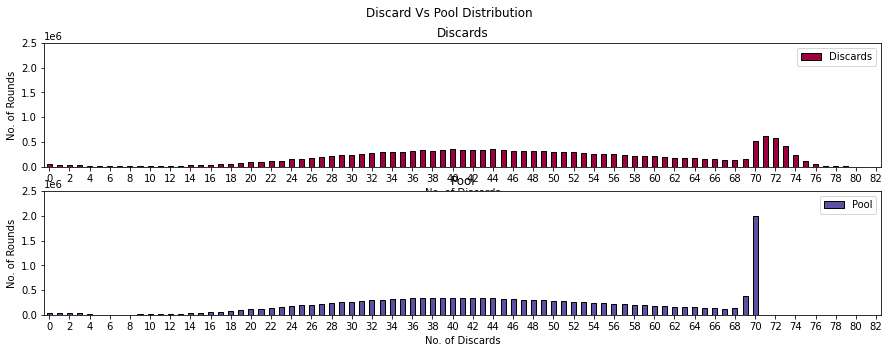

In [367]:
accumulated_df.plot.bar(rot=0, stacked=False, figsize=(15, 5), subplots=True, edgecolor='black', linewidth=1, legend=True, 
                        title='Discard Vs Pool Distribution',
                        sharex=False,
                        sharey=True,
                        xticks=np.arange(min_rating, max_words + tick_shift, tick_shift),
                        yticks=np.arange(0, max_reviews + y_shift, y_shift),
                        xlabel="No. of Discards",
                        ylabel='No. of Rounds',
                        colormap='Spectral',
                        fontsize=10
#                         grid=True
                       )


# plt.figure(figsize=(20, 5))
# ax = plt.gca()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# ax.set_axisbelow(True)
# ax.tick_params(axis='x', rotation=0)

# plt.bar(list(discard_count_df.total_discards.value_counts(sort=False).index), 
#         list(discard_count_df.total_discards.value_counts(sort=False)), 
#         align='center',
#         edgecolor='black', 
#         linewidth=1.2
# )

# plt.bar(list(discard_count_df.total_pool_size.value_counts(sort=False).index), 
#         list(discard_count_df.total_pool_size.value_counts(sort=False)), 
#         align='center',
#         edgecolor='black', 
#         linewidth=1.2
# )

# plt.title("Total Discards Distribution", fontsize=17)

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# ax = plt.gca()
# ax.set_axisbelow(True)

# plt.xticks(np.arange(min_rating, max_words + tick_shift, tick_shift))
# plt.yticks(np.arange(0, max_reviews + y_shift, y_shift))
# plt.ylim(0, max_reviews)

# plt.xlabel("No. of Discards", fontsize=15)
# plt.ylabel("No. of Rounds", fontsize=15)
# plt.savefig(imdb_graphs_output / 'IMDB_length_unprocessed_en', bbox_inches='tight')
# plt.gca().ticklabel_format(axis='both', style='plain')

plt.show()

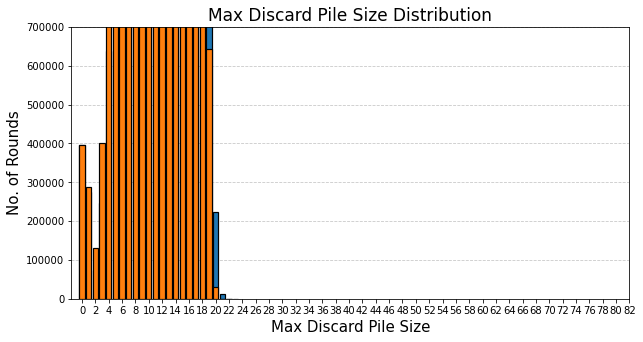

In [320]:
cm = plt.cm.get_cmap('Spectral')  # Other noteworthy ones: 'plasma', 'Spectral'

plt.figure(figsize=(10, 5))
ax = plt.gca()
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.tick_params(axis='x', rotation=0)

plt.bar(list(all_players_discards.value_counts(sort=False).index), 
        list(all_players_discards.value_counts(sort=False)), 
        align='center',
        edgecolor='black', 
        linewidth=1.2
)

plt.bar(list(all_players_pool.value_counts(sort=False).index), 
        list(all_players_pool.value_counts(sort=False)), 
        align='center',
        edgecolor='black', 
        linewidth=1.2
)

plt.title("Max Discard Pile Size Distribution", fontsize=17)
plt.xticks(np.arange(min_rating, max_words + tick_shift, tick_shift))
plt.yticks(np.arange(0, max_reviews + y_shift, y_shift))
plt.ylim(0, max_reviews)

plt.xlabel("Max Discard Pile Size", fontsize=15)
plt.ylabel("No. of Rounds", fontsize=15)
# plt.savefig(imdb_graphs_output / 'IMDB_length_unprocessed_en', bbox_inches='tight')
plt.gca().ticklabel_format(axis='both', style='plain')

plt.show()

# print("Number of Players:", players)
# print("Number of occurence not shown:", sum((x > max_words or x < min_rating) for x in average_table_ratings))